In [8]:
import numpy as np
import  matplotlib.pyplot as plt
import scipy.special as sp

# source

In [9]:
def source(no_of_users, no_of_bits):
    # Generate a random binary matrix with shape (no_of_users, no_of_bits)
    # Each element is either 0 or 1
    return np.random.randint(0, 2, (no_of_users, no_of_bits))

no_of_users = 2  # Define the number of users
no_of_bits = 8  # Define the number of bits per user

# Generate the message bits as a binary matrix
msg_bits1 = source(no_of_users, no_of_bits)  # Generating bit stream of size (no_of_users, no_of_bits)
# Print the generated message bits
print("msg\n", msg_bits1)  # Each row represents the bit stream for one user


msg
 [[1 1 1 0 0 0 0 1]
 [0 0 1 0 0 1 0 0]]


# modulationn

In [10]:
def mod(bits):
    # Map binary values: 0 to -1 and 1 to 1
    return 2 * bits - 1

# Apply modulation to the message bits
symbols = mod(msg_bits1)
print(symbols)

[[ 1  1  1 -1 -1 -1 -1  1]
 [-1 -1  1 -1 -1  1 -1 -1]]


# channel

In [11]:
def awgn_mac_with_channel_coeff(symbols, snr_db):
    # Sum the columns of the symbols array to combine signals from different users

    #cahnnel coefficienst
    channel_coeff=np.random.randn(len(symbols[0]))
    
    faded_symbols=symbols*channel_coeff# This corresponds to y = x_i * h_i
    # Print combined symbols for debugging (commented out)
    
    combined_faded_symbols = np.sum(faded_symbols, axis=0)# This corresponds to y = ∑x_i * h_i
    # print(combined_symbols)   
    
    # Calculate the average power of the combined signal
    signal_power = np.mean(np.abs(combined_faded_symbols)**2)  # Signal power calculation

    # Convert SNR from dB to linear scale
    snr_linear = 10**(snr_db / 10.0)
    
    # Calculate noise variance based on the signal power and SNR
    noise_variance = signal_power / (2 * snr_linear)

    # Generate complex Gaussian noise with the calculated variance
    noise = np.sqrt(noise_variance) * np.random.randn(len(combined_faded_symbols))  # Generating noise with accordance with signal power

    #multiplying with channel coeff
    # channel_coeff=np.random.randn(len(combined_symbols))
    # Add the noise to the combined symbols and return the result
    return combined_faded_symbols + noise,combined_faded_symbols

# Define the SNR in dB (array with one value in this case)
snr_db = np.arange(2, 3, 1)

# Pass the modulated symbols through the AWGN channel
received_signal,faded_symbols = awgn_mac_with_channel_coeff(symbols, snr_db)

# Print the received signal after adding noise
print("y=:\n",received_signal,"\n","∑x_i * h_i=:\n",faded_symbols)

y=:
 [ 0.79580342 -0.42333198 -1.49964837 -0.87934484  0.26709321 -0.44225193
  5.46339186  2.17321558] 
 ∑x_i * h_i=:
 [ 0.          0.         -1.18707432 -1.35154028 -0.35900821  0.
  3.91202056  0.        ]


# Demodulation

In [12]:
def demod(received_signal,faded_symbols):
    # print(received_signal)

    # Initialize an empty list to store the demodulated symbols
    demodulated_symbols = []
    
    # Iterate over each received signal to decode it
    for i in received_signal:
        # print(i)
        # Find the closest symbol to the received signal based on minimum distance
        closest_symbol = min(faded_symbols, key=lambda s: np.abs(i - s))  # Decoding by finding the minimum distance
        # print(closest_symbol)
        demodulated_symbols.append(closest_symbol)  # Append the closest symbol to the list
    # print(demodulated_symbols)

    # Convert the list of demodulated symbols to a numpy array and return it
    return np.array(demodulated_symbols)



# Perform demodulation on the received signal   
demod_symbols = demod(received_signal,faded_symbols)
# Print the demodulated symbols
print(demod_symbols)
# print(np.sum(symbols,axis=0))

[ 0.         -0.35900821 -1.35154028 -1.18707432  0.         -0.35900821
  3.91202056  3.91202056]


## BER calculation

In [13]:
def ber_bpsk_sum_with_fading(msg, recovered):
    # Modulate the original message bits to get the transmitted symbols
    sym1 = mod(msg)
    
    # Sum the transmitted symbols across all users
    combined_symbols = np.sum(sym1, axis=0)  # This is used to compare with the received symbols
    # print(combined_symbols)
    
    # Print statements for debugging (currently commented out)
    # print(msg)
    # msg_sum = np.sum(msg, axis=0)
    # print("\n", msg_sum)
    # print("\n", rec)

    # Calculate the Bit Error Rate (BER) by comparing the combined transmitted symbols with the received symbols
    ber = np.mean(combined_symbols != recovered)  # BER is calculated by averaging the number of symbol errors
    
    return ber

# Calculate the Bit Error Rate (BER) using the original message bits and the demodulated symbols
BER = ber_bpsk_sum_with_fading(msg_bits1, demod_symbols)

# Print the calculated BER
print(BER)


0.875


## simulation

In [14]:
# Function to simulate the system for different SNR values
def simulate_mac_with_fading(snr_db_range, msg_bits, no_of_users, no_of_bits):
    ber_with_channel_coeff = []  # Initialize an empty list to store Symbol Error Rate (SER) for each SNR value

    # Iterate over the range of SNR values
    for snr_db in snr_db_range:
        # Print the current SNR value for debugging (commented out)
        # print("snr=", snr_db)
        
        # Modulate the message bits to obtain transmitted symbols
        transmitted_symbols = mod(msg_bits)  # Modulation: bit stream --> symbols
        # print(transmitted_symbols)
          
        # Pass the transmitted symbols through the AWGN channel to get received symbols
        received_symbols,faded_symbols = awgn_mac_with_channel_coeff(transmitted_symbols, snr_db)  # Received symbols: channel output = symbols + noise
        # print("received\n",received_symbols)
        
        # Demodulate the received symbols to recover the transmitted symbols
        demodulated_symbols = demod(received_symbols,faded_symbols)  # Demodulation: noisy_symbols --> decoded symbols
        # print("demodulated\n",demodulated_symbols)
        
        # ber_with_channel_coeff=ber_bpsk_sum_with_fading(msg_bits,demodulated_symbols)
        # print(ber_with_channel_coeff)
        ber_with_channel_coeff.append(ber_bpsk_sum_with_fading(msg_bits, demodulated_symbols)) 
        # Demodulate the received symbols to recover the transmitted symbo>
        # print("\n\n")

    return ber_with_channel_coeff   # Return the list of SER values for the given range of SNR values



# Define the range of SNR values (in dB) for the simulation
snr_db_range = np.arange(0, 12, 1)  # Input for SNR range to plot

# Run the simulation to obtain SER for each SNR value
ber_bpsk_sum_with_fading=simulate_mac_with_fading(snr_db_range, msg_bits1, no_of_users, no_of_bits)

# Print the Bit Error Rate (BER) for each SNR value
# print(ber_bpsk_sum_with_channel_coeff)
 

print(ber_bpsk_sum_with_fading)

[0.625, 0.75, 1.0, 0.75, 0.625, 0.75, 0.875, 0.75, 0.625, 0.5, 0.75, 0.5]


### plotting

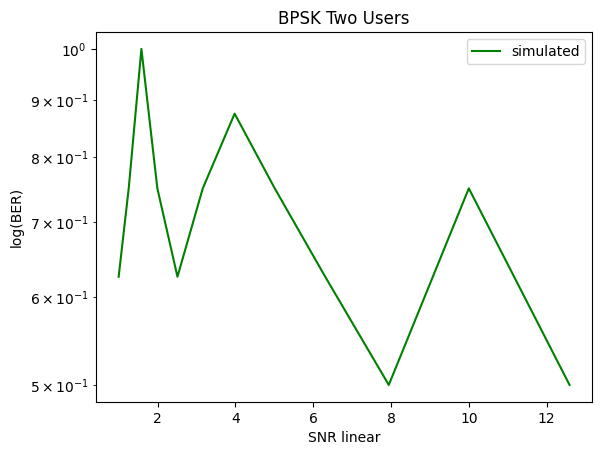

In [15]:
# Convert SNR values from dB to linear scale
snr_lin = 10**(snr_db_range / 10)  # SNR in linear scale


# Plot the simulated BER values
plt.semilogy(snr_lin, ber_bpsk_sum_with_fading, linestyle='-', color="g", label='simulated')

#theoritical values
# plt.semilogy(snr_lin,1/((1*snr_lin)), linestyle='--', color="r", label='theoritical')

plt.xlabel("SNR linear")  
plt.ylabel("log(BER)")       
plt.legend()         
plt.title("BPSK Two Users") 
# plt.grid(True)
plt.show()
